In [5]:
import matplotlib.pyplot as plt
import sys
import numpy as np

In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
from keras.preprocessing.image import array_to_img,img_to_array,load_img

In [1]:
DATADIR = "./Original"
CATEGORIES = ["class1", "class2"]
IMG_SIZE_x = 70
IMG_SIZE_y = 19
training_data = []
def create_training_data():
    for class_num, category in enumerate(CATEGORIES):
        path = os.path.join(DATADIR, category)
        for image_name in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)  # 画像読み込み
                img_resize_array = cv2.resize(img_array, (IMG_SIZE_x, IMG_SIZE_y))  # 画像のリサイズ
                training_data.append([img_resize_array, class_num])  # 画像データ、ラベル情報を追加
            except Exception as e:
                pass
create_training_data()

NameError: name 'os' is not defined

学習データのラベル： 1
学習データのラベル： 0
学習データのラベル： 1
学習データのラベル： 1


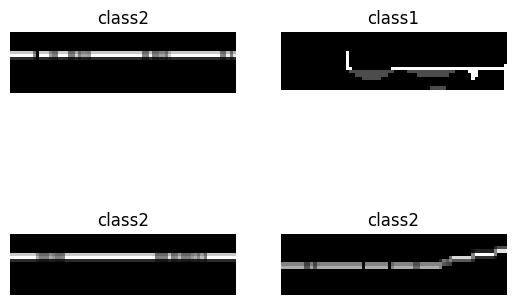

In [34]:
random.shuffle(training_data)  # データをシャッフル
X_train = []  # 画像データ
y_train = []  # ラベル情報
# データセット作成
for feature, label in training_data:
    X_train.append(feature)
    y_train.append(label)
# numpy配列に変換
X_train = np.array(X_train)
y_train = np.array(y_train)
# データセットの確認
for i in range(0, 4):
    print("学習データのラベル：", y_train[i])
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.title(label = 'class1' if y_train[i] == 0 else 'class2')
    plt.imshow(X_train[i], cmap='gray')
plt.show()

In [4]:
X_train=[]
Y_train=[]

X_test=[]
Y_test=[]

i=os.listdir("./Original/class2")
n=0
for target_file in i:
    image=("./Original/class2/"+target_file)
    temp_img=load_img(image)
    temp_img_array=img_to_array(temp_img)
    print(temp_img_array.shape)
    X_train.append(temp_img_array)
    n=n+1

np.savez("./gan/gan.npz",x_train=X_train,y_train=Y_train,x_test=X_test,y_test=Y_test)

NameError: name 'load_img' is not defined

In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1 
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset

        f=np.load("/home/gan/gan.npz")
        X_train=f["x_train"]
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.


        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))


        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]


            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("gan/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=200)



In [ ]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)
